In [1]:
import os
import json
import string
import pickle
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from matplotlib.colors import ListedColormap
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

from processor import Log

In [2]:
stop = stopwords.words('english') + list(string.punctuation)

In [3]:
with open('oov_dictionary.pickle', 'rb') as f:
    oov_dict = pickle.load(f)

# Log Loader

In [4]:
def load_logs(log_repository, data_path):

    filepath = os.path.join(data_path, log_repository)
    print("Loading logs from {}...".format(filepath))

    missing_counter = 0
    file_count = 0
    for _, _, files in os.walk(filepath):
        file_count += len(files)
    print("{} files found.".format(file_count))
    logs = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.endswith(".json"):
                with open(os.path.join(root, file), 'r') as logfile:
                    log = Log(json.load(logfile))
                    if log.complete:
                        logs.append(log)

    print("DONE. Loaded {} completed game logs.".format(len(logs)))
    return logs

In [5]:
data_path = ""
logs = load_logs("logs", data_path)

Loading logs from logs...
2502 files found.
DONE. Loaded 2502 completed game logs.


# Transcript Printer

In [6]:
def print_transcript(log):
    print("Game ID: {}".format(log.game_id))
    print("Domain ID: {}".format(log.domain_id))
    print("Image set main objects: '{}' and '{}'".format(log.domains[0], log.domains[1]))
    print("Participant IDs: {} and {}".format(log.agent_ids[0], log.agent_ids[1]))
    print("Start Time: {}".format(log.start_time))
    print("Duration: {}".format(log.duration))
    print("Total Score: {}".format(log.total_score))
    print("Player scores: A - {}, B - {}".format(log.scores["A"], log.scores["B"]))
    print("Transcript:\n")

    for round_data in log.rounds:
        print("Round {}".format(round_data.round_nr))
        for message in round_data.messages:
            if message.type == "text":
                print("[{}] {}: {}".format(Log.format_time(message.timestamp), message.speaker, message.text))

            if message.type == "selection":
                label = "common" if message.text.split()[1] == "<com>" else "different"
                print("[{}] {} marks image {} as {}".format(Log.format_time(message.timestamp), message.speaker, Log.strip_image_id(message.text.split()[2]), label))

        print("\nDuration: {}".format(round_data.duration))
        print("Total Score: {}".format(round_data.total_score))        
        print("Player scores: A - {}, B - {}".format(round_data.scores["A"], round_data.scores["B"]))
        print("Number of messages: {}\n".format(round_data.num_messages))


# Data Collector

In [7]:
def collect_game_statistics(games_df, filtering=None, participants=None):

    game_statistics = []

    f = FloatProgress(min=0, max=len(games_df))
    display(f)

    for game_ID, game_df in games_df:
        
        if participants:
            agents = set([game_df['Agent_1'].unique().tolist()[0], game_df['Agent_2'].unique().tolist()[0]])
            if not participants.issuperset(agents):
                f.value += 1
                continue
        
        game_entry = [game_ID]
        token_set = set()
        content_token_set = set()
        
        if filtering:
            last_selection = game_df.index[game_df['Message_Type'] == 'selection'].tolist()[-1]
            end_time = game_df.loc[[last_selection]]["Message_Timestamp"].tolist()[0]
            start_time = game_df.iloc[[0]]["Message_Timestamp"].tolist()[0]            
            game_entry.append((end_time - start_time).total_seconds())
        else:
            game_entry.append(game_df['Game_Duration'].unique().tolist()[0]) 
        
        game_entry.append(game_df['Game_Score'].unique().tolist()[0])
            
        for round_nr, round_df in game_df.groupby('Round_Nr'):
            round_entry = [round_nr]            
            if (filtering == 'last' and round_nr == 5) or filtering == 'all':
                last_selection = round_df.index[round_df['Message_Type'] == 'selection'].tolist()[-1]
                end_time = round_df.loc[[last_selection]]["Message_Timestamp"].tolist()[0]
                start_time = round_df.iloc[[0]]["Message_Timestamp"].tolist()[0]
                round_entry.append((end_time - start_time).total_seconds())
            else:
                round_entry.append(round_df['Round_Duration'].unique().tolist()[0])

            messages = []
            if (filtering == 'last' and round_nr == 5) or filtering == 'all':
                for player_label, player_df in round_df.groupby('Message_Agent_ID'):    

                    last_selection = player_df.index[player_df['Message_Type'] == 'selection'].tolist()[-1]
                    for index, row in player_df.iterrows():
                        if row['Message_Type'] == 'text':
                            messages.append(row['Message_Text'])
                        elif row['Message_Type'] == 'selection' and index == last_selection:
                            break
            else:
                messages = round_df.loc[round_df['Message_Type'] == 'text']['Message_Text'].tolist()            

            tokens = []
            for message in messages:   
                m_tokens = [i for i in word_tokenize(message.lower())]
                m_tokens_spell = [word if word not in oov_dict else oov_dict[word] for word in m_tokens]
                tokens.extend(m_tokens_spell)

            content_tokens = [i for i in tokens if i not in stop]
            token_count = len(tokens)
            content_count = len(content_tokens)
            
            if len(messages) > 0:
                token_message_ratio = token_count / float(len(messages))
            else: 
                token_message_ratio = 0
            
            unique_tokens = set(tokens) 
            unique_content_tokens = set(content_tokens) 
            
            unique_token_count = len(unique_tokens)
            unique_content_count = len(unique_content_tokens)
            
            prev_unique_tokens = len(token_set)
            prev_content_tokens = len(content_token_set)

            token_set = token_set.union(unique_tokens)
            content_token_set = content_token_set.union(unique_content_tokens)

            new_tokens = len(token_set) - prev_unique_tokens
            new_content_tokens = len(content_token_set) - prev_content_tokens

            score = round_df.mean()["Round_Scores"]
            
            if token_count > 0:
                unique_ratio = unique_token_count/float(token_count)
                content_ratio = content_count/float(token_count) 
            else:
                unique_ratio = content_ratio = 0
            if unique_token_count > 0:
                content_unique_ratio = unique_content_count/float(unique_token_count)
            else:
                content_unique_ratio = 0
            
            round_entry.extend([score, len(messages), token_count, token_message_ratio, content_count, unique_token_count, unique_content_count, \
                                new_tokens, new_content_tokens, unique_ratio, content_ratio, content_unique_ratio])
                  
            game_statistics.append(game_entry + round_entry)    
            
        f.value += 1

    game_statistics_df = pd.DataFrame(game_statistics, columns=["Game_ID", "Game_Duration", "Game_Score", "Round_Nr", \
                         "Duration", "Score", "Messages", "Tokens", "Tokens/Message", "Content", "Unique", "Unique_Content", \
                         "New", "New_Content", "Unique/Total", "Content/Total", "Unique_Content/Unique"])
    
    return game_statistics_df

In [8]:
def collect_dataset(logs):
    labels = ["Game_ID", "Game_Domain_ID", "Game_Domain_1", "Game_Domain_2", "Game_Duration", "Game_Score", \
              "Feedback_A", "Feedback_B", 'Agent_1', "Agent_2", \
              "Round_Nr", "Round_Duration", "Round_Scores", "Round_Images_A", "Round_Images_B", \
              "Round_Common", "Round_Highlighted_A", "Round_Highlighted_B",\
              "Message_Nr", "Message_Timestamp", "Message_Turn", "Message_Agent_ID", \
              "Message_Speaker", "Message_Type", "Message_Text"]
    dataset = []
    for log in logs:
        game_data = [log.game_id, log.domain_id, log.domains[0], log.domains[1], log.duration.total_seconds(), log.total_score, log.feedback["A"], log.feedback["B"], log.agent_ids[0], log.agent_ids[1]]
        for game_round in log.rounds:
            round_data = [game_round.round_nr-1, game_round.duration.total_seconds(), game_round.total_score, game_round.images["A"], game_round.images["B"], game_round.common, game_round.highlighted["A"], game_round.highlighted["B"]]
            for message in game_round.messages:
                message_data = [message.message_id, message.timestamp, message.turn, message.agent_id, \
                                message.speaker, message.type, message.text] 
                dataset.append(game_data + round_data + message_data)
                
    df = pd.DataFrame(dataset, columns=labels)
                
    return df 

In [9]:
dataset = collect_dataset(logs)

In [10]:
dataset.to_csv('dataset.csv', index = False)

In [11]:
dataset.to_pickle('dataset.pickle')

In [12]:
games_df = dataset.groupby('Game_ID')

# Data Filter

In [13]:
def collect_worker_data(logs):
    worker_data = []

    for log in logs:
        worker_1, worker_2 = log.agent_ids
        timestamp = log.start_time
        score = log.total_score
        messages = 0
        tokens = []

        for r, round_data in enumerate(log.rounds):
            for message in round_data.messages:
                if message.type == "text":
                    messages += 1
                    tokens.extend(word_tokenize(message.text))   

        content_tokens = [i for i in tokens if i not in stop]
        token_count = len(tokens)
        content_count = len(content_tokens)

        unique_tokens = set(tokens) 
        unique_content_tokens = set(content_tokens) 

        unique_token_count = len(unique_tokens)
        unique_content_count = len(unique_content_tokens)

        if token_count > 0:
            unique_ratio = unique_token_count/float(token_count)
            content_ratio = content_count/float(token_count) 
        else:
            unique_ratio = content_ratio = 0
        if unique_token_count > 0:
            content_unique_ratio = unique_content_count/float(unique_token_count)
        else:
            content_unique_ratio = 0   

        worker_data.append([worker_1, timestamp, score, log.duration.total_seconds(), messages, token_count, content_count, \
                            unique_token_count, unique_content_count, unique_ratio, content_ratio, content_unique_ratio])
        worker_data.append([worker_2, timestamp, score, log.duration.total_seconds(), messages, token_count, content_count, \
                            unique_token_count, unique_content_count, unique_ratio, content_ratio, content_unique_ratio])
    return pd.DataFrame(worker_data, columns=["Worker_ID", "Timestamp", "Score", "Duration", "Messages", \
    "Tokens", "Content", "Unique", "Unique_Content", "Unique/Total", "Content/Total", "Unique_Content/Unique"])

In [14]:
worker_data = collect_worker_data(logs)

In [15]:
worker_data.to_csv('worker_data.csv', index = False)

In [16]:
worker_data.to_pickle('worker_data.pickle')

## Reduce dataset to participants who completed at least 2 games 

In [17]:
game_data_first = []

for worker_ID, data in worker_data.groupby("Worker_ID"):
    sorted_data = data.sort_values(by=['Timestamp'])   
    if len(sorted_data) < 2 or len(sorted_data) > 5:
        continue
        
    for i, (index, entry) in enumerate(sorted_data.iterrows()):
        game_data_first.append([i+1] + [i for i in entry])
        
game_data_df_first = pd.DataFrame(game_data_first, columns=["Game_Nr", "Worker_ID", "Timestamp", "Score", "Duration", "Messages", \
    "Tokens", "Content", "Unique", "Unique_Content", "Unique/Total", "Content/Total", "Unique_Content/Unique"])
game_data_df_first = game_data_df_first.drop(["Timestamp"], axis = 1)
game_data_df_first.to_pickle("game_data_df_first.pickle")

In [18]:
two_games_workers = game_data_df_first['Worker_ID'].unique().tolist()

# Analysis

In [19]:
game_statistics_df = collect_game_statistics(games_df, filtering='all', participants = set(two_games_workers))

FloatProgress(value=0.0, max=2502.0)

In [20]:
game_statistics_df.to_csv('game_statistics.csv', index = False)

In [21]:
game_statistics_df.to_pickle('game_statistics.pickle')

## Efficiency

/home/janosch/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/janosch/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


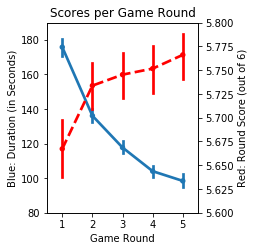

In [22]:
dimensions = (2.7,3.5)

fig, temp = plt.subplots(1, figsize=dimensions)

title = 'Duration per Game Round'
x_label = 'Game Round'
y_label_1 = 'Blue: Duration (in Seconds)'

selector = "Round_Nr"
variable = "Duration"
filename = 'acl_efficiency'

sns.pointplot(data=game_statistics_df, x=selector, y=variable, markers=["."])
ax = plt.twinx()

title = 'Scores per Game Round'
x_label = 'Game Round'
y_label_2 = 'Red: Round Score (out of 6)'

selector = "Round_Nr"
variable = "Score"

sns.pointplot(data=game_statistics_df, x=selector, y=variable, color="r", linestyles=["--"], markers=["."])   
ax.set_title(title)
temp.set_xlabel(x_label)
temp.set_ylabel(y_label_1)
ax.set_ylabel(y_label_2)
ax.set_ylim(5.6,5.8)
temp.set_ylim(80, 190)
temp = plt.gca().xaxis.grid(True, linestyle='--')
fig.show()
fig.savefig("figures/{}.pdf".format(filename), bbox_inches='tight')


## Content Token Ratio

/home/janosch/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


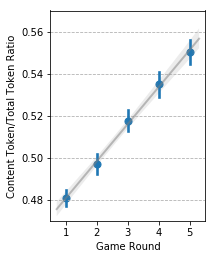

In [23]:
dimensions = (3.1,3.7)
fig, ax = plt.subplots(1, figsize=dimensions)

title = 'Ratio of Content Tokens vs. Total Tokens'
x_label = 'Game Round'
y_label = 'Content Token/Total Token Ratio'

selector = "Round_Nr"
variable = "Content/Total"
filename = 'acl_ratio_content'

sns.regplot(x=selector, y=variable, marker="o", data=game_statistics_df, x_estimator=np.mean, line_kws={'color': 'gray', "alpha":0.5,"lw":2})
plt.ylim(0.47,0.57)
plt.xlim(0.5,5.5)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.tick_params(labelsize=10,labelcolor="black")
plt.gca().yaxis.grid(True, linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig("figures/{}.pdf".format(filename), bbox_inches='tight')

## Novel Tokens

In [24]:
game_statistics_df["Novel_Content_Ratio"] = game_statistics_df["New_Content"] / game_statistics_df["Content"]

/home/janosch/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


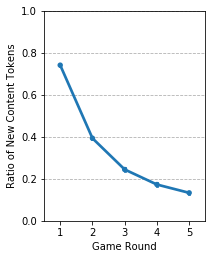

In [25]:
fig, ax = plt.subplots(1, figsize=dimensions)

title = 'Tokens Introduced to the Conversation'
x_label = 'Game Round'
y_label = 'Ratio of New Content Tokens'

selector = "Round_Nr"
variable = "Novel_Content_Ratio"
filename = 'acl_new_tokens'

sns.pointplot(data=game_statistics_df, x=selector, y=variable, markers=["."])   
plt.xlabel("Game Round")
plt.ylabel(y_label)
plt.gca().yaxis.grid(True, linestyle='--')
plt.ylim(0,1)

plt.tight_layout()
plt.show()
fig.savefig("figures/{}.pdf".format(filename), bbox_inches='tight')

# Linguistic Analysis

In [26]:
def collect_pos_tag_statistics(games_df, filtering=None):

    pos_statistics = []

    f = FloatProgress(min=0, max=len(games_df))
    display(f)

    for game_ID, game_df in games_df:        
        for round_nr, round_df in game_df.groupby('Round_Nr'):                  
            messages = []
            if (filtering == 'last' and round_nr == 5) or filtering == 'all':
                for player_label, player_df in round_df.groupby('Message_Agent_ID'):    

                    last_selection = player_df.index[player_df['Message_Type'] == 'selection'].tolist()[-1]
                    for index, row in player_df.iterrows():
                        if row['Message_Type'] == 'text':
                            messages.append(row['Message_Text'])
                        elif row['Message_Type'] == 'selection' and index == last_selection:
                            break
            else:
                messages = round_df.loc[round_df['Message_Type'] == 'text']['Message_Text'].tolist()            

            pos_tags = []
            for message in messages:   
                m_tokens = [i for i in word_tokenize(message.lower())]
                m_tokens_spell = [word if word not in oov_dict else oov_dict[word] for word in m_tokens]
                pos_tags += [item[1] for item in pos_tag(m_tokens_spell, tagset='universal')]
                
                
            if len(pos_tags) == 0:
                continue
            pos_tag_dict = dict()       
            for key,value in dict(Counter(pos_tags)).items():
                pos_tag_dict[key] = [value]  
            pos_tag_dict['Round_Nr'] = round_nr
            round_entry_df = pd.DataFrame.from_dict(pos_tag_dict)
            pos_statistics.append(round_entry_df)
            
        f.value += 1
        
    pos_statistics_df = pd.concat(pos_statistics)
    return pos_statistics_df


In [27]:
pos_statistics_df = collect_pos_tag_statistics(games_df, 'last')

FloatProgress(value=0.0, max=2502.0)

/home/janosch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [28]:
pos_statistics_df = pos_statistics_df.fillna(0)

## POS-Tag Distribution

In [29]:
top_10 = ['NOUN', 'DET', 'VERB', 'ADP', 'ADJ', '.', 'ADV', 'NUM', 'PRON', 'CONJ']

In [30]:
labels_10 = []
sum_list = []

for round_nr, round_data in pos_statistics_df.groupby('Round_Nr'):
    round_data = round_data[top_10]
    sum_list.append(round_data.sum(axis = 0).tolist())
    labels_10 = round_data.sum(axis = 0).keys()

In [31]:
pos_tag_df = pd.DataFrame(sum_list, columns = labels_10, index=[1,2,3,4,5])

In [32]:
pos_tag_df = pos_tag_df.div(pos_tag_df.sum(axis=1), axis=0)

In [33]:
def generate_pos_distribution(pos_tag_df):
                    
#     top_10 = ['NOUN', 'DET', 'VERB', 'ADP', 'ADJ', '.', 'ADV', 'NUM', 'PRON', 'CONJ']
    top_10 = ['NOUN', 'VERB', 'ADJ', 'ADV']

    my_cmap = ListedColormap(sns.color_palette("Paired", 10).as_hex())
    colors = [list(my_cmap(i)) for i in range(10)]
    colors = colors[0:4] + [colors[5]] + [colors[4]] + colors[6:]
    colors = np.asarray(colors)

    filename = "figures/pos_tag_distribution.pdf"
    title = "POS-Tag Distribuion per Round"
    x_label = "Game Round"
    y_label = "Relative POS-Tag Distribution"
    fig_size = (4,3.5)

    fig, ax = plt.subplots(1, figsize=fig_size)
    ax = pos_tag_df.plot.bar(stacked=True, color=colors, ax=ax, width=1);

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc='upper center', title='POS-Tag', bbox_to_anchor=(1.2, 0.92), ncol=1)
    ax.set_ylim(0,1)
    ax.set_xlim(-0.5,4.5)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    plt.xticks(rotation='horizontal')
    fig.show()
    fig.savefig(filename, bbox_inches='tight')
       
    for compare_to in range(5,6):
        print(compare_to)
        filename = "figures/pos_tag_change_to{}.pdf".format(compare_to)
        title = "POS-Tag Distribution Change between Round 1 and {}".format(compare_to)
        x_label = "POS-Tag"
        y_label = "Change in relaticve Distribution"
        fig_size = (2.4,3.5)
    
        change_list = [] 
        for pos_tag in top_10:
            entries = pos_tag_df[pos_tag].values
            change_list.append([pos_tag, (entries[compare_to-1] - entries[0]) / entries[0]])
        
        change_df = pd.DataFrame(change_list, columns=["Tag", "Change"])
        print(change_df)
            
        fig, ax = plt.subplots(1, figsize=fig_size)
        change_df.plot.bar(x = "Tag", color=colors, ax=ax, width=0.7);
        for i, bar in enumerate(ax.patches):
            bar.set_color(colors[i%10])
            bar.set_hatch(hatch="//")
            
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend("")
        ax.legend_.remove()
        ax.set_ylim(-0.3,0.3)
        plt.gca().yaxis.grid(True)
        ax.set_axisbelow(True)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
        plt.xticks(rotation='horizontal')

        fig.show()
        fig.savefig(filename, bbox_inches='tight')

/home/janosch/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/janosch/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


5
    Tag    Change
0  NOUN  0.198088
1  VERB -0.173258
2   ADJ  0.078287
3   ADV  0.118085


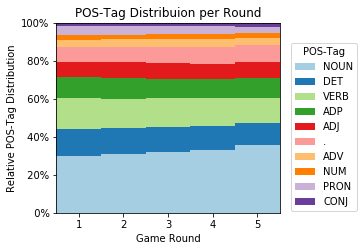

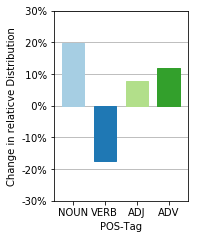

In [34]:
generate_pos_distribution(pos_tag_df)